In [261]:
# Forcer l'affichage de toutes les sorties d'une cellule jupyter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Preprocessing
## Objectif: 
**Mettre les données dans un format propice à la modélisation**

In [262]:
import sys
import os
import yaml

# fonction pour charger les configurations de config.yaml
def load_config(config_path='C:/Users/DELL/Documents/VEMV/pycaret/work/Diamond_cut_prediction/config/config.yaml'):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# chargement des configurations
config = load_config()

# Ajout du dossier 'src' au chemin Python
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

# importation du module
from data_loader import load_raw_data

In [263]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [264]:
# chargement du dataset
path = config['data']['raw_path']
data = load_raw_data(path)
df = data.copy()
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [265]:
# suppression de la colonne des index redondante
def delete_Unnamed_column(df):
    df.drop('Unnamed: 0', axis=1, inplace=True)
    return df

In [ ]:
# création des ensembles d'entrainement et de test
def split(df):
    df = df.drop('price', axis=1)   # D'un point de vue metier, inclure la variable price pour predire la qualite de la coupe n'a aucun sens 
    x , y = train_test_split(df, train_size=0.8, shuffle=True, stratify=df['cut'])
    return x, y

In [267]:
trainset, testset = split(df)
testset.cut.value_counts(normalize=True)

cut
Ideal        0.399518
Premium      0.255654
Very Good    0.224045
Good         0.090934
Fair         0.029848
Name: proportion, dtype: float64

In [268]:
# suppression des doublons
def gestion_doublons(df):
    df = df.drop_duplicates()
    return(df)

### Les variables color et clarity sont ordonées, donc le label encoding est nécessaire

In [269]:
# encodage categoriel
def cat_encoding(df):
    color_map = {'D': 1, 'E': 2, 'F': 3, 'G': 4, 'H': 5, 'I': 6, 'J': 7}
    clarity_map = {'IF': 1, 'VVS1': 2, 'VVS2': 3, 'VS1':4, 'VS2': 5, 'SI1': 6, 'SI2': 7, 'I1': 8}
    cut_map = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}

    df['color'] = df['color'].map(color_map)
    df['clarity'] = df['clarity'].map(clarity_map)
    df['cut'] = df['cut'].map(cut_map)
    return df

In [270]:
# gestion des outliers
def gestion_outliers(df):
    df = df[(df['depth'] > 51.5) &
            (df['depth'] < 75) &
            (df['carat'] < 3.4) &
            (df['table'] > 48) &
            (df['table'] < 75) &
            (df['x'] > 2) &
            (df['y'] > 2) &
            (df['y'] < 15) &
            (df['z'] > 1) &
            (df['z'] < 10)  
            ]
    return df

In [271]:
# preprocessing proprement dit
def preprocessing(df):
    df = delete_Unnamed_column(df)
    df = gestion_doublons(df)
    df = gestion_outliers(df)
    df = cat_encoding(df)
    x = df.drop('cut', axis=1)
    y = df['cut']
    
    return x, y

x_train, y_train = preprocessing(trainset)

In [272]:
x_test, y_test = preprocessing(testset)
x_test.shape

(10768, 8)

In [273]:
x_train.shape

(42894, 8)

In [274]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

# Modelling

In [275]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve, StratifiedKFold
#from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [276]:
# Modèle deep learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

In [277]:
# Estimateurs
dt = DecisionTreeClassifier(random_state=2)
rf = RandomForestClassifier(random_state=2, class_weight='balanced')
lgbm = LGBMClassifier(objective='multiclass',random_state=2, verbose=-1, is_unbalance=True)
brf = BalancedRandomForestClassifier(random_state=2, sampling_strategy='auto',
                                replacement=False, bootstrap=True)

In [278]:
# Architechture du réseau
ANN = Sequential()

ANN.add(Dense(88, activation='relu', input_shape=(x_train.shape[1],)))
ANN.add(Dropout(0.1))
ANN.add(Dense(40, activation='relu'))
ANN.add(Dense(20, activation='relu'))
ANN.add(Dense(10, activation='relu'))
ANN.add(Dense(5, activation='softmax'))

# compilation
ANN.compile(optimizer=Adam(learning_rate=0.001), 
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

c:\Users\DELL\Documents\VEMV\pycaret\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [279]:
models = {
    'DecisionTree': dt,
    'Balanced Random Forest': brf,
    'LightGBM': lgbm,
    'ANN': ANN
}

In [280]:
# fonction d'évaluation
def evaluation(model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    epochs=50
    batch_size=120
    scaler = StandardScaler()
    if model == ANN:
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)
        history= model.fit(x_train, y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.1,
                  verbose=1)
        y_pred_proba= model.predict(x_test)
        y_pred = np.argmax(y_pred_proba, axis=1)

        #matrice de confusion
        disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
        plt.title('matrice de confusion')
        plt.grid(False)
        plt.show()
        
        print('Classification report')
        print(classification_report(y_test, y_pred, digits=3))
        print(f"Quadratic Weighted Kappa {cohen_kappa_score(y_test, y_pred, weights='quadratic')}")
        print(f"cohen kappa {cohen_kappa_score(y_test, y_pred)}")

        #learning curve
        plt.plot(history.history['loss'], label='Training')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.xlabel('epochs')
        plt.ylabel('crossentropy')
        plt.title("Courbe d'apprentissage")
        plt.legend()
        plt.show()

    else:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        
        #matrice de confusion
        disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
        plt.title('matrice de confusion')
        plt.grid(False)
        plt.show()
        
        print('Classification report')
        print(classification_report(y_test, y_pred, digits=3))
        print(f"Quadratic Weighted Kappa {cohen_kappa_score(y_test, y_pred, weights='quadratic')}")
        print(f"cohen kappa {cohen_kappa_score(y_test, y_pred)}")

        # learning curve
        kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2) # je l'utilise pour garder les memes proportions des différentes classes
        N, train_score, val_score = learning_curve(model, x_train, y_train, scoring=kappa_scorer,
                                                    cv=cv, train_sizes= np.linspace(0.1, 1, 10))
        plt.figure()
        plt.plot(N, train_score.mean(axis=1), label='training')
        plt.plot(N, val_score.mean(axis=1), label='validation')
        plt.ylabel('Quadratic Weighted Kappa')
        plt.title("Courbe d'apprentissage")
        plt.legend()
        plt.show()

=================================== Evaluation de DecisionTree ======================================== 


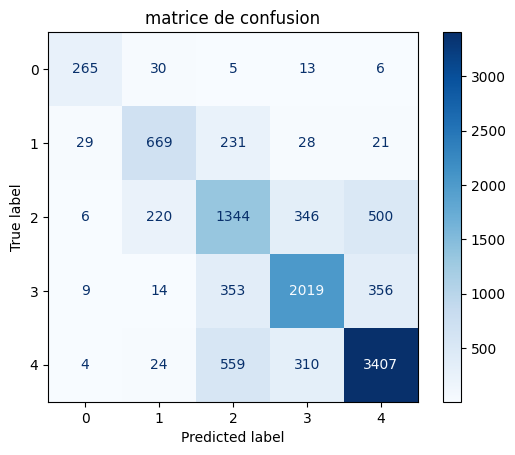

Classification report
              precision    recall  f1-score   support

           0      0.847     0.831     0.839       319
           1      0.699     0.684     0.691       978
           2      0.539     0.556     0.548      2416
           3      0.743     0.734     0.739      2751
           4      0.794     0.792     0.793      4304

    accuracy                          0.715     10768
   macro avg      0.725     0.719     0.722     10768
weighted avg      0.717     0.715     0.716     10768

Quadratic Weighted Kappa 0.7348961739873836
cohen kappa 0.6022884156212889


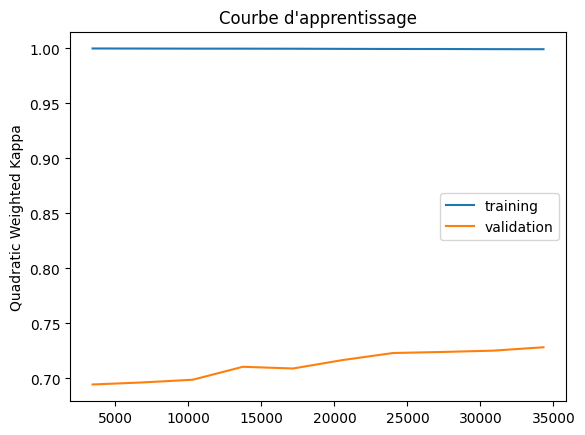

=================================== Evaluation de Balanced Random Forest ======================================== 


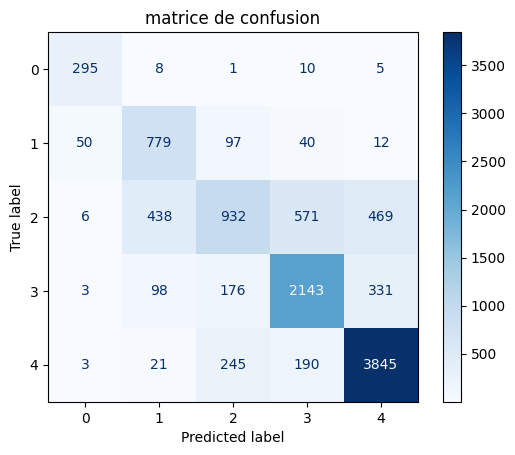

Classification report
              precision    recall  f1-score   support

           0      0.826     0.925     0.873       319
           1      0.580     0.797     0.671       978
           2      0.642     0.386     0.482      2416
           3      0.725     0.779     0.751      2751
           4      0.825     0.893     0.858      4304

    accuracy                          0.742     10768
   macro avg      0.720     0.756     0.727     10768
weighted avg      0.736     0.742     0.730     10768

Quadratic Weighted Kappa 0.7922113775547771
cohen kappa 0.6393513581074399


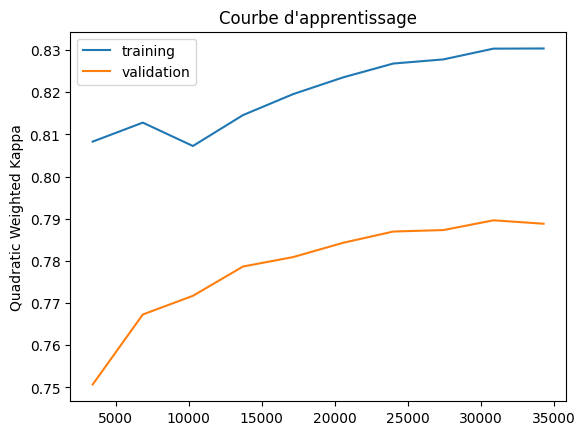

=================================== Evaluation de LightGBM ======================================== 


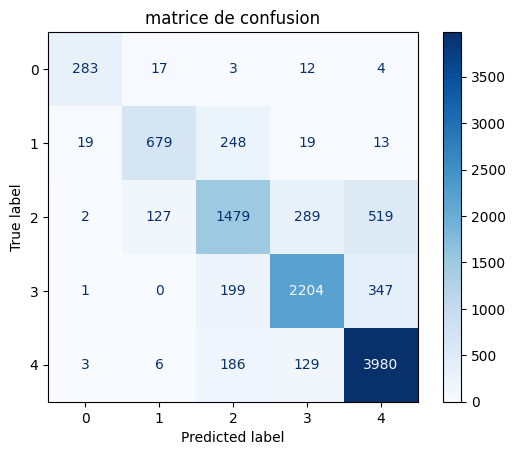

Classification report
              precision    recall  f1-score   support

           0      0.919     0.887     0.903       319
           1      0.819     0.694     0.752       978
           2      0.699     0.612     0.653      2416
           3      0.831     0.801     0.816      2751
           4      0.818     0.925     0.868      4304

    accuracy                          0.801     10768
   macro avg      0.817     0.784     0.798     10768
weighted avg      0.798     0.801     0.797     10768

Quadratic Weighted Kappa 0.823650613556377
cohen kappa 0.7175618310960113


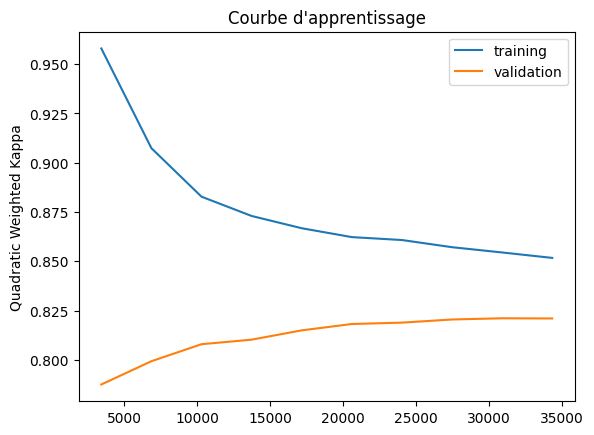

=================================== Evaluation de ANN ======================================== 
Epoch 1/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5266 - loss: 1.2370 - val_accuracy: 0.7012 - val_loss: 0.8034
Epoch 2/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6921 - loss: 0.8010 - val_accuracy: 0.7126 - val_loss: 0.7651
Epoch 3/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6974 - loss: 0.7727 - val_accuracy: 0.7191 - val_loss: 0.7430
Epoch 4/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7028 - loss: 0.7614 - val_accuracy: 0.7207 - val_loss: 0.7418
Epoch 5/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7127 - loss: 0.7428 - val_accuracy: 0.7254 - val_loss: 0.7298
Epoch 6/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7150 - loss: 0.7355 - val_accuracy: 0.7294 - val_loss: 0.7203
Epoch 7/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7128 - loss: 0.7385 - val_accuracy: 0.7361 - val_loss: 0.7052
Epoch 8/

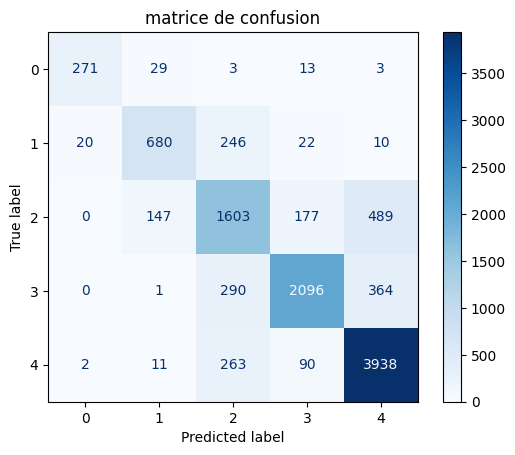

Classification report
              precision    recall  f1-score   support

           0      0.925     0.850     0.886       319
           1      0.783     0.695     0.737       978
           2      0.667     0.663     0.665      2416
           3      0.874     0.762     0.814      2751
           4      0.820     0.915     0.865      4304

    accuracy                          0.798     10768
   macro avg      0.814     0.777     0.793     10768
weighted avg      0.799     0.798     0.796     10768

Quadratic Weighted Kappa 0.8184831173834916
cohen kappa 0.7134620171201094


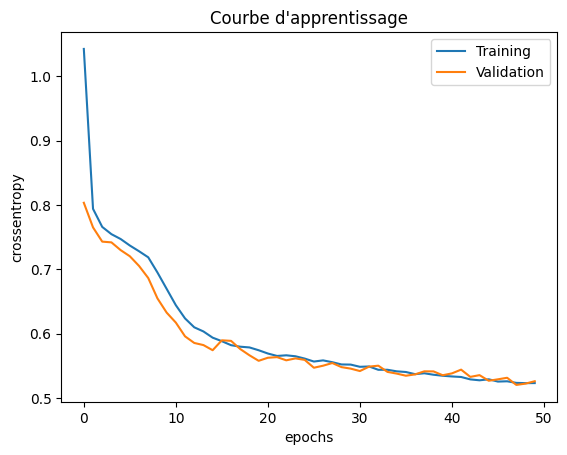

In [281]:
for name, model in models.items():
    print(f'=================================== Evaluation de {name} ======================================== ')
    evaluation(model)
    #print('='*100)